In [1]:
import re
import json
import pandas as pd
from pathlib import Path
from qwen_math_parser import extract_answer, strip_string
from grader import math_equal
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Accuracy

In [2]:
result_df = pd.read_csv(Path.cwd().parent / "results" / "merged_accuracy.csv")

In [3]:
result_df = result_df[
    ~((result_df.method == "kl-divergence") & (result_df.n_reasoning_steps < 3))
]

In [4]:
forward_pass_summary_df = (
    result_df[result_df.method == "forward-pass"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

In [5]:
majority_vote_df = (
    result_df[result_df.method == "majority-vote"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

In [6]:
kl_divergences_df = (
    result_df[result_df.method == "kl-divergence"]
    .groupby(["model_id", "n_samples", "response_number", "dataset"], as_index=False)[
        "accuracy"
    ]
    .mean()
)

## MATH500

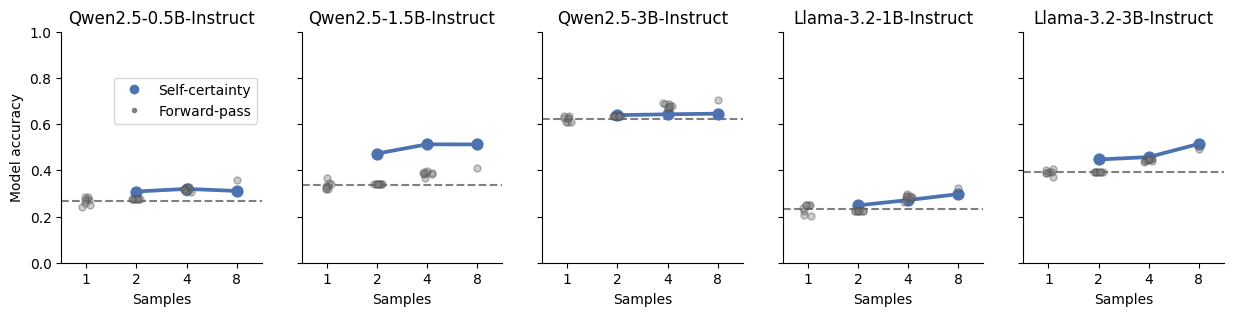

In [7]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=5, sharey=True)
for i, model_id in enumerate(
    [
        "Qwen/Qwen2.5-0.5B-Instruct",
        "Qwen/Qwen2.5-1.5B-Instruct",
        "Qwen/Qwen2.5-3B-Instruct",
        "meta-llama/Llama-3.2-1B-Instruct",
        "meta-llama/Llama-3.2-3B-Instruct",
    ]
):
    title = model_id[5:] if i <= 2 else model_id[11:]
    # Forward pass
    sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="grey",
        data=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Forward pass",
        linewidth=1,
        alpha=0.4,
    )

    ax[i].axhline(
        y=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "math500")
        ].accuracy.mean(),
        linestyle="--",
        color="grey",
    )

    # KL divergences
    sns.pointplot(
        x="n_samples",
        y="accuracy",
        color="#4c72b0",
        data=kl_divergences_df[
            (kl_divergences_df.model_id == model_id)
            & (kl_divergences_df.dataset == "math500")
        ],
        ax=ax[i],
        label="KL divergences",
    )

    # Majority vote
    sns.stripplot(
        x="n_samples",
        y="accuracy",
        color="grey",
        data=majority_vote_df[
            (majority_vote_df.model_id == model_id)
            & (majority_vote_df.dataset == "math500")
        ],
        ax=ax[i],
        label="Majority vote",
        linewidth=1,
        alpha=0.4,
    )
    ax[i].set(title=title, ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

for i in range(0, 5):
    ax[i].legend_.remove()

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        linestyle="None",
        color="#4c72b0",
        lw=2,
        label="Self-certainty",
    ),
    Line2D(
        [0], [0], marker=".", linestyle="None", color="grey", lw=2, label="Forward-pass"
    ),
]

fig.legend(
    handles=legend_elements,
    bbox_to_anchor=(0.26, 0.75),
)

sns.despine()

plt.savefig(
    Path.cwd().parent / "figures" / "figure_1.pdf", bbox_inches="tight", dpi=300
)

# GSM8K

## Accuracy

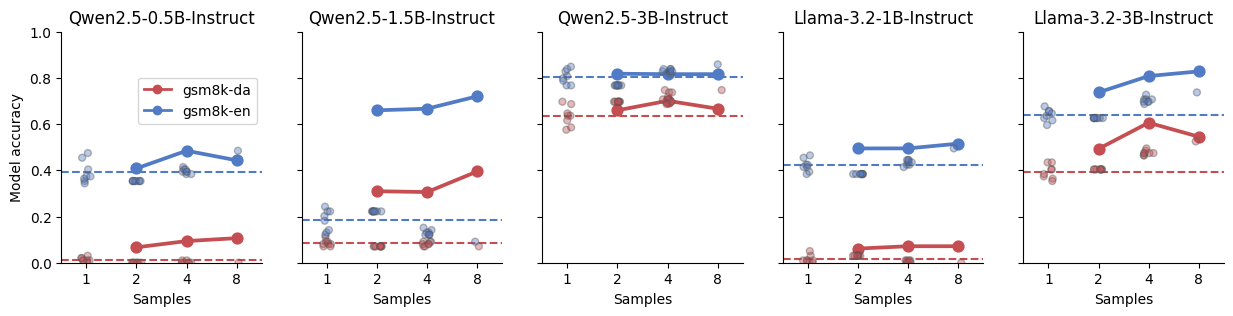

In [8]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=5, sharey=True)
for i, model_id in enumerate(
    [
        "Qwen/Qwen2.5-0.5B-Instruct",
        "Qwen/Qwen2.5-1.5B-Instruct",
        "Qwen/Qwen2.5-3B-Instruct",
        "meta-llama/Llama-3.2-1B-Instruct",
        "meta-llama/Llama-3.2-3B-Instruct",
    ]
):
    title = model_id[5:] if i <= 2 else model_id[11:]

    # Forward pass
    sns.stripplot(
        x="n_samples",
        y="accuracy",
        palette={"gsm8k-en": "#527bc6", "gsm8k-da": "#c44e52"},
        data=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset.isin(["gsm8k-en", "gsm8k-da"]))
        ],
        ax=ax[i],
        hue="dataset",
        linewidth=1,
        alpha=0.4,
    )

    ax[i].axhline(
        y=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "gsm8k-en")
        ].accuracy.mean(),
        linestyle="--",
        color="#527bc6",
    )
    ax[i].axhline(
        y=forward_pass_summary_df[
            (forward_pass_summary_df.model_id == model_id)
            & (forward_pass_summary_df.dataset == "gsm8k-da")
        ].accuracy.mean(),
        linestyle="--",
        color="#c44e52",
    )

    # KL divergences
    sns.pointplot(
        x="n_samples",
        y="accuracy",
        palette={"gsm8k-en": "#527bc6", "gsm8k-da": "#c44e52"},
        data=kl_divergences_df[
            (kl_divergences_df.model_id == model_id)
            & (kl_divergences_df.dataset.isin(["gsm8k-en", "gsm8k-da"]))
        ],
        hue="dataset",
        ax=ax[i],
    )

    # Majority vote
    sns.stripplot(
        x="n_samples",
        y="accuracy",
        palette=["#c44e52", "#527bc6"],
        data=majority_vote_df[
            (majority_vote_df.model_id == model_id)
            & (majority_vote_df.dataset.isin(["gsm8k-en", "gsm8k-da"]))
        ],
        ax=ax[i],
        hue="dataset",
        linewidth=1,
        alpha=0.4,
    )
    ax[i].set(title=title, ylim=(0, 1), xlabel="Samples")
ax[0].set(ylabel="Model accuracy")

for i in range(0, 5):
    ax[i].legend_.remove()

legend_elements = [
    Line2D([0], [0], marker="o", color="#c44e52", lw=2, label="gsm8k-da"),
    Line2D([0], [0], marker="o", color="#527bc6", lw=2, label="gsm8k-en"),
]

fig.legend(
    handles=legend_elements,
    bbox_to_anchor=(0.26, 0.75),
)

sns.despine()

plt.savefig(
    Path.cwd().parent / "figures" / "figure_2.pdf", bbox_inches="tight", dpi=300
)